In [138]:
from imp import reload   
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

os.chdir("/Users/bytedance/MLTrader-deploy")

In [118]:
from research.orderbook_strategies.utils import helper
from research.orderbook_strategies.utils import factors

reload(helper)

<module 'research.orderbook_strategies.utils.helper' from '/Users/bytedance/MLTrader-deploy/research/orderbook_strategies/utils/helper.py'>

### 疑似crash的时刻 
- OP：20230720 14:35:00
- OP：20230717 18:30:00
- OP：20230717 10:20:00
- OP：20230716 02:20:00 插针回拉

In [97]:
product_list = ["OPUSDT", "BTCUSDT"]
columns = ["time", "bid", "ask", "bid.qty", "ask.qty", "next.bid", "next.ask", "atr.4096", "std.4096", "max.4096", "min.4096"] + helper.BASIK_TICK_FILED
columns = list(set(columns))
datas = []
for product in product_list:
    data = helper.get_data(product, "2023-07-16", columns=columns)
    data["time"] = pd.to_datetime(data["time"])
    datas.append(data)

In [111]:
X1 = datas[0].set_index('time')
X2 = datas[1].set_index('time')

X1_sub = X1.loc["2023-07-16 00": "2023-07-16 03"]
X2_sub = X2.loc["2023-07-16 00": "2023-07-16 03"]

X1_sub["wpr_normalized"] = X1_sub["wpr"] / X1_sub["wpr"].iloc[0]
X2_sub["wpr_normalized"] = X2_sub["wpr"] / X2_sub["wpr"].iloc[0]
# perform the merge
# newX1 = pd.merge_asof(X1, X2[["wpr", "bid", "ask", "next_bid", "next_ask"]], left_index=True, right_index=True, direction='backward', suffixes=('', '.y'))
# assert np.all(X1.index == newX1.index)

<AxesSubplot:xlabel='time'>

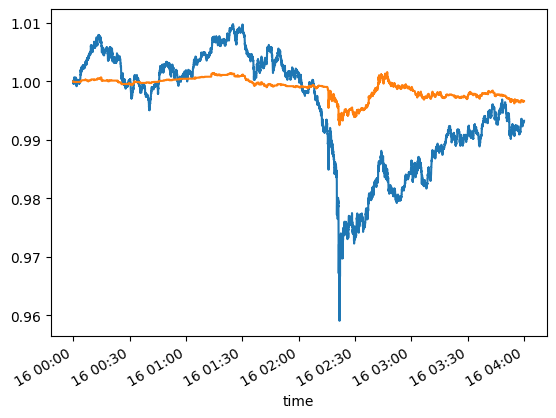

In [115]:
X1_sub["wpr_normalized"].plot()
X2_sub["wpr_normalized"].plot()

In [116]:
# volatility 加权
X1_sub["vwap"] = (X1_sub["wpr_normalized"] * X1_sub["quote_qty"]).cumsum() / X1_sub["quote_qty"].cumsum()
X2_sub["vwap"] = (X2_sub["wpr_normalized"] * X2_sub["quote_qty"]).cumsum() / X2_sub["quote_qty"].cumsum()

<AxesSubplot:xlabel='time'>

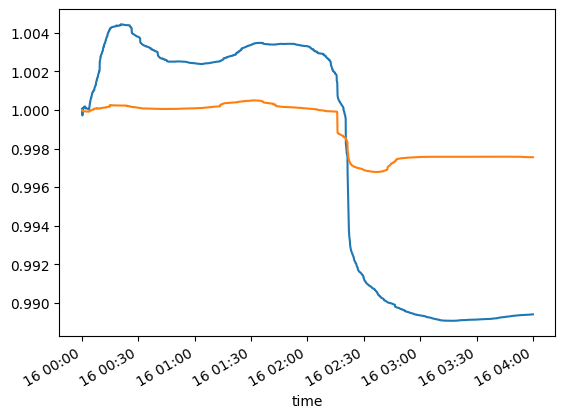

In [117]:
X1_sub["vwap"].plot()
X2_sub["vwap"].plot()

In [121]:
X1_sub["atr.4096"] = factors.foctor_atr_period().formula(X1_sub, 4096)

In [129]:
# 
X1_sub["max.32"] = X1_sub["wpr"].rolling(32).max()
X1_sub["min.32"] = X1_sub["wpr"].rolling(32).min()
plus = (X1_sub["max.32"].diff(1) > 0)
minus = (X1_sub["min.32"].diff(1) < 0)
X1_sub["plus_score"] = helper.ewma(plus, 32)
X1_sub["minus_score"] = helper.ewma(minus, 32)
X1_sub["dx"] = abs(X1_sub["plus_score"] - X1_sub["minus_score"]) / (X1_sub["plus_score"] + X1_sub["minus_score"])
X1_sub["adx.1024"] = helper.ewma(X1_sub["dx"], 1024)

Text(0, 0.5, 'active.sell.qty')

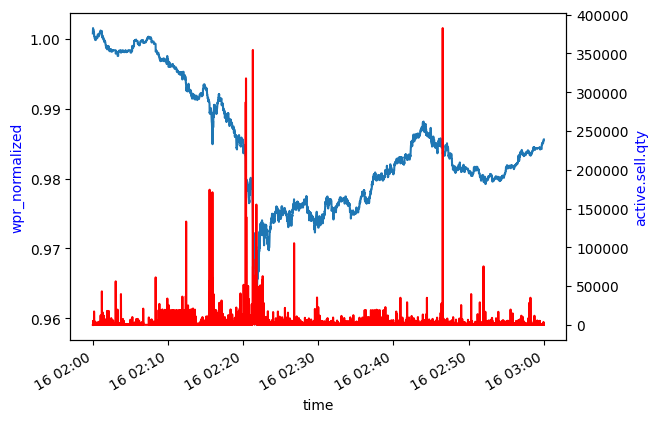

In [141]:
ax1 = X1_sub["wpr_normalized"].loc["2023-07-16 02"].plot()
ax2 = ax1.twinx()
X1_sub["active.sell.qty"].loc["2023-07-16 02"].plot(ax=ax2, color="red")
ax1.set_ylabel('wpr_normalized', color='blue')
ax2.set_ylabel('active.sell.qty', color='blue')

Text(0, 0.5, 'active.buy.qty')

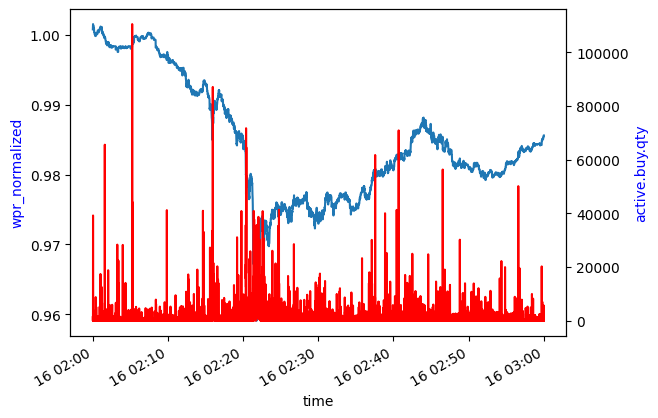

In [142]:
ax1 = X1_sub["wpr_normalized"].loc["2023-07-16 02"].plot()
ax2 = ax1.twinx()
X1_sub["active.buy.qty"].loc["2023-07-16 02"].plot(ax=ax2, color="red")
ax1.set_ylabel('wpr_normalized', color='blue')
ax2.set_ylabel('active.buy.qty', color='blue')

<AxesSubplot:xlabel='time'>

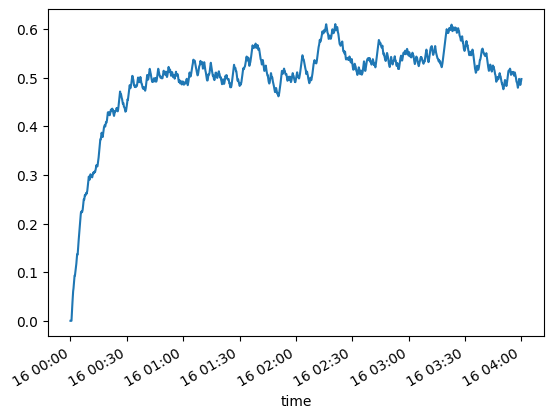

In [136]:
X1_sub["adx.1024"].plot()

In [93]:
def get_buy_sell_ratio(tick, period):
    buy_power = helper.cum(tick["active.buy.quote_qty"], period)
    sell_power = helper.cum(tick["active.sell.quote_qty"], period)
    ratio = buy_power / (buy_power + sell_power + 1e-12)
    return ratio

def get_future_price_move(tick, period):
    return tick["wpr"].diff(period).fillna(0).shift(-period)

period = 512
price_move = get_future_price_move(X2, period)
buy_sell_ratio = get_buy_sell_ratio(X2, period)

state = np.zeros(len(X2))
state = np.where((buy_sell_ratio >= 0.5) & (price_move >= 0), 1, state) # 买方控场涨
state = np.where((buy_sell_ratio >= 0.5) & (price_move < 0), 2, state) # 买方控场跌
state = np.where((buy_sell_ratio < 0.5) & (price_move < 0), 3, state) # 卖方控场跌
state = np.where((buy_sell_ratio < 0.5) & (price_move >= 0), 4, state) # 卖方控场涨

In [94]:
state = state[::512]

In [95]:
transitions = np.zeros((5, 5))
for i in range(len(state) - 1):
    transitions[int(state[i])-1, int(state[i + 1])-1] += 1